# Learning the committor with graph neural networks (GNNs)
[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/luigibonati/mlcolvar/blob/main/docs/notebooks/tutorials/adv_gnn_based_cvs.ipynb)

In [ ]:
# Colab setup
import os

if os.getenv("COLAB_RELEASE_TAG"):
    import subprocess
    subprocess.run('wget https://raw.githubusercontent.com/luigibonati/mlcolvar/main/colab_setup.sh', shell=True)
    cmd = subprocess.run('bash colab_setup.sh TUTORIAL', shell=True, stdout=subprocess.PIPE)
    print(cmd.stdout.decode('utf-8'))

## Common variables

In [ ]:
T = 300 

# Boltzmann factor in the RIGHT ENERGY UNITS!
kb = 0.0083144621 # kJ/mol
beta = 1/(kb*T)

## Load data

In [220]:
import torch
from mlcolvar.cvs.committor.utils import compute_committor_weights
from mlcolvar.data import DictModule
from mlcolvar.utils.io import create_dataset_from_trajectories, load_dataframe

# loading arguments for each file
load_args = [{'start' : 0, 'stop' : 10000, 'stride' : 2},
             {'start' : 0, 'stop' : 10000, 'stride' : 2}]

# create dataset from trajectory files, xyz and anything compatible with MDtraj can be used
dataset = create_dataset_from_trajectories(trajectories=["/home/etrizio@iit.local/notebooks/projects/gnn_committor/alanine/unbiased/A/traj_comp.xtc",     
                                                         "/home/etrizio@iit.local/notebooks/projects/gnn_committor/alanine/unbiased/B/traj_comp.xtc"],
                                           top="/home/etrizio@iit.local/notebooks/projects/gnn_committor/alanine/unbiased/B/confAvac.gro", # with xyz use none                 
                                           cutoff=10.0,    # Angstrom        
                                           labels=None,                    
                                           system_selection='all and not type H', # this uses MDtraj selection syntax
                                           show_progress=False,
                                           load_args=load_args,
                                           lengths_conversion=10.0, # MDTraj uses nm by defualt, we use Angstroms
                                        )
print('Dataset info:\n', dataset, end="\n\n")


# load corresponding colvar files, the easiest thing is to print in synch trajectory and COLVAR files!
colvar = load_dataframe(["/home/etrizio@iit.local/notebooks/projects/gnn_committor/alanine/unbiased/A/COLVAR",     
                        "/home/etrizio@iit.local/notebooks/projects/gnn_committor/alanine/unbiased/B/COLVAR"],
                        start=0,
                        stop=10000,
                        stride=2)


# initialize weights, here we have unbiased simulations so no bias
bias = torch.zeros(len(dataset))
dataset = compute_committor_weights(dataset=dataset,
                                    bias=bias, 
                                    data_groups=[0,1], 
                                    beta=beta)


# load dataset into a DictModule
datamodule = DictModule(dataset, lengths=[1])
print('Datamodule info:\n', datamodule)

Dataset info:
 DictDataset( "data_list": 10000, "z_table": [6, 7, 8], "cutoff": 10.0, "used_idx": tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), "used_names": [ACE1-CH3, ACE1-C, ACE1-O, ALA2-N, ALA2-CA, ALA2-CB, ALA2-C, ALA2-O, NME3-N, NME3-C], "data_type": graphs )

Datamodule info:
 DictModule(dataset -> DictDataset( "data_list": 10000, "z_table": [6, 7, 8], "cutoff": 10.0, "used_idx": tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), "used_names": [ACE1-CH3, ACE1-C, ACE1-O, ALA2-N, ALA2-CA, ALA2-CB, ALA2-C, ALA2-O, NME3-N, NME3-C], "data_type": graphs ),
		     train_loader -> DictLoader(length=1, batch_size=10000, shuffle=True))


In [216]:
from mlcolvar.core.nn.graph import SchNetModel
from mlcolvar.cvs import Committor
import copy 

# initialize GNN model, here we use SchNet
gnn_model = SchNetModel(n_out=1,
                        cutoff=dataset.metadata['cutoff'],
                        atomic_numbers=dataset.metadata['z_table'],
                        n_bases=16,
                        n_layers=2,
                        n_filters=16,
                        n_hidden_channels=16,
                        aggr='mean',
                        w_out_after_pool=True,
                    )

# model options
options = {'optimizer' : {'lr' : 1e-3},
           'lr_scheduler': {
            'scheduler': torch.optim.lr_scheduler.ExponentialLR,
            'gamma': 0.99995
        }}

# initialize committor model
model = Committor(model=gnn_model, 
                  atomic_masses=torch.Tensor([12.011, 14.007, 15.999]), # C, N, O
                  alpha=100,
                  separate_boundary_dataset=False, # here we only have the boundary dataset
                  z_regularization=100,
                  z_threshold=5,
                  log_var=True,
                  gamma=1,
                  options=options)

# save the model sigmoid to switch easily between q and z
sigmoid = copy.deepcopy(model.sigmoid)

/home/etrizio@iit.local/Bin/miniconda3/envs/graph_mlcolvar_test_2.5/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


In [217]:
from lightning import Trainer
from mlcolvar.utils.trainer import MetricsCallback

# define callbacks
metrics = MetricsCallback()

# initialize lightning trainer
trainer = Trainer(
    callbacks=[metrics],
    logger=False,
    enable_checkpointing=False,
    accelerator='cuda',
    max_epochs=2000,
    enable_model_summary=False,
    limit_val_batches=0, 
    num_sanity_val_steps=0
)

# fit model on datamodule
trainer.fit(model, datamodule)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/etrizio@iit.local/Bin/miniconda3/envs/graph_mlcolvar_test_2.5/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=2000` reached.


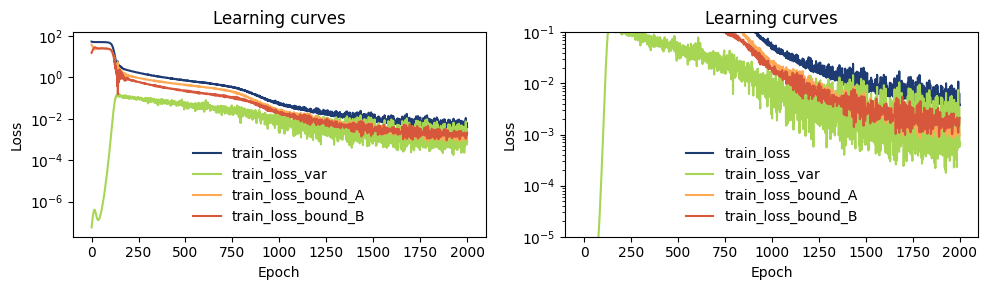

In [218]:
from mlcolvar.utils.plot import plot_metrics
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,2,figsize=(10,3))
for ax in axs:
    plot_metrics(metrics.metrics,
                    keys=['train_loss', 'train_loss_var', 'train_loss_bound_A', 'train_loss_bound_B'],
                    colors=['fessa0', 'fessa3', 'fessa5', 'fessa6'],
                    yscale='log',
                    ax = ax)

# we zoom more in one plot
axs[1].set_ylim(1e-5, 1e-1)

plt.tight_layout()

torch.Size([10000])


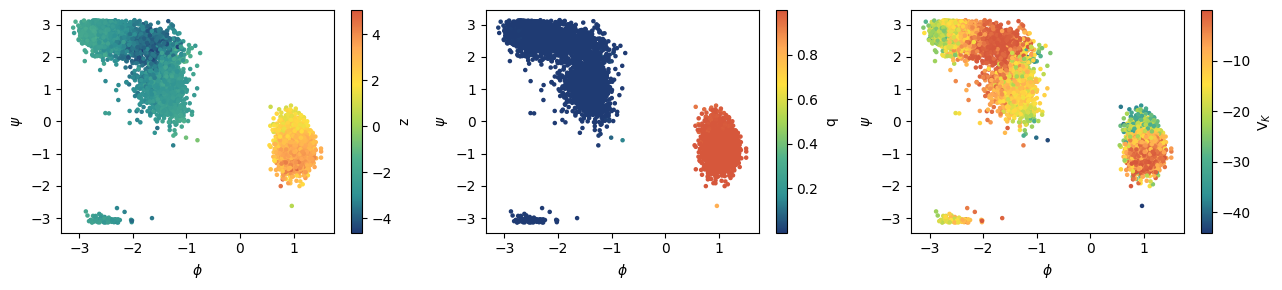

In [221]:
from mlcolvar.cvs.committor.utils import KolmogorovBias

fig, axs = plt.subplots(1,3,figsize=(13,3))

# compute and plot z value over training set
model.sigmoid = None
with torch.no_grad(): out_z = model(dataset.get_graph_inputs())

ax = axs[0]
cp = ax.scatter(colvar['phi'], colvar['psi'], c=out_z, s=5, cmap='fessa')
plt.colorbar(cp, ax=ax, label='z')
ax.set_ylabel("$\psi$")
ax.set_xlabel("$\phi$")



# compute and plot q value over training set
model.sigmoid = sigmoid
with torch.no_grad(): out_q = model(dataset.get_graph_inputs()).detach()

ax = axs[1]
cp = ax.scatter(colvar['phi'], colvar['psi'], c=out_q, s=5, cmap='fessa')
plt.colorbar(cp, ax=ax, label='q')
ax.set_ylabel("$\psi$")
ax.set_xlabel("$\phi$")



# compute and plot V_K value over training set
bias_model = KolmogorovBias(model, beta)
bias = bias_model(dataset.get_graph_inputs())

ax = axs[2]
cp = ax.scatter(colvar['phi'], colvar['psi'], c=bias, s=5, cmap='fessa')
plt.colorbar(cp, ax=ax, label='V$_K$')
ax.set_xlabel("$\phi$")
ax.set_ylabel("$\psi$")


plt.tight_layout()

In [223]:
# export z model
model.sigmoid = None
traced_model = model.to_torchscript('gnn_model_iter_0_z.pt', method='trace')

# export q model
model.sigmoid = sigmoid
traced_model = model.to_torchscript('gnn_model_iter_0_q.pt', method='trace')


# we can also check the outputs coincide
torch.allclose(model(dataset.get_graph_inputs()), traced_model(dataset.get_graph_inputs()))

/home/etrizio@iit.local/Bin/dev/mlcolvar/mlcolvar/data/datamodule.py:322: UserWarning: Length of split at index 1 is 0. This might result in an empty dataset.
  warnings.warn(


True

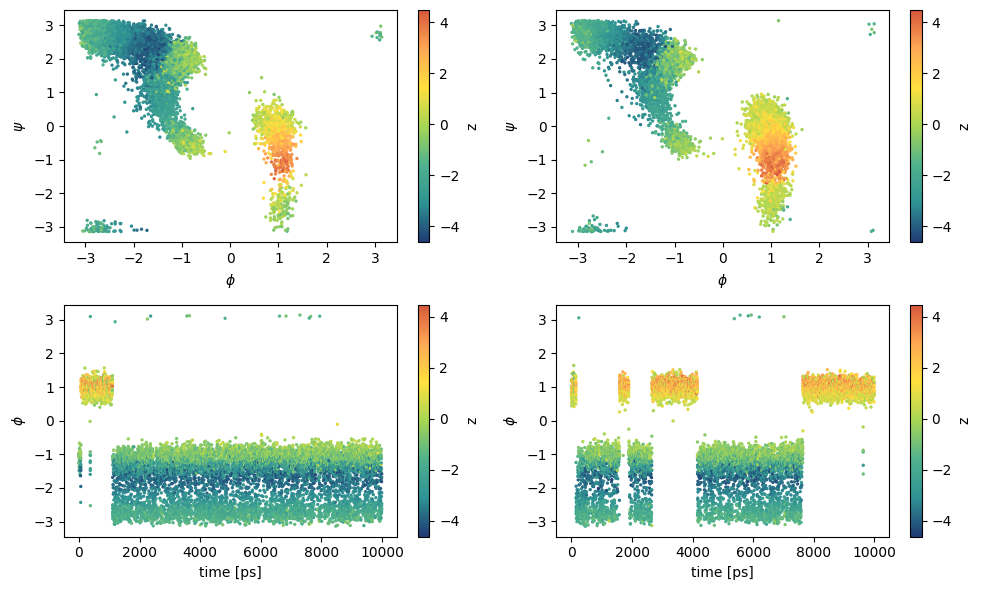

In [257]:
fig, axs = plt.subplots(2,2,figsize=(10,6))

ax = axs[0, 0]
sampling = load_dataframe("/home/etrizio@iit.local/notebooks/projects/gnn_committor/alanine/biased/iter_0/A/COLVAR", stop=-5)
cp = ax.scatter(sampling['phi'], sampling['psi'], c=sampling['gnn.node-z'], cmap='fessa', s=2)
plt.colorbar(cp, ax = ax, label='z')
ax.set_xlabel('$\phi$')
ax.set_ylabel('$\psi$')

ax = axs[1, 0]
cp = ax.scatter(sampling['time'], sampling['phi'], c=sampling['gnn.node-z'], cmap='fessa', s=2)
plt.colorbar(cp, ax = ax, label='z')
ax.set_xlabel('time [ps]')
ax.set_ylabel('$\phi$')

ax = axs[0, 1]
sampling = load_dataframe("/home/etrizio@iit.local/notebooks/projects/gnn_committor/alanine/biased/iter_0/B/COLVAR", stop=-5)
cp = ax.scatter(sampling['phi'], sampling['psi'], c=sampling['gnn.node-z'], cmap='fessa', s=2)
plt.colorbar(cp, ax = ax, label='z')
ax.set_xlabel('$\phi$')
ax.set_ylabel('$\psi$')

ax = axs[1, 1]
cp = ax.scatter(sampling['time'], sampling['phi'], c=sampling['gnn.node-z'], cmap='fessa', s=2)
plt.colorbar(cp, ax = ax, label='z')
ax.set_xlabel('time [ps]')
ax.set_ylabel('$\phi$')


plt.tight_layout()
plt.show()

In [233]:
# loading arguments for each file
load_args = [{'start' : 0, 'stop' : 10000, 'stride' : 1},
             {'start' : 0, 'stop' : 10000, 'stride' : 1}]

# create dataset from trajectory files, xyz and anything compatible with MDtraj can be used
test_dataset = create_dataset_from_trajectories(trajectories=["/home/etrizio@iit.local/notebooks/projects/gnn_committor/alanine/biased/A/traj_comp.xtc",     
                                                         "/home/etrizio@iit.local/notebooks/projects/gnn_committor/alanine/biased/B/traj_comp.xtc"],
                                           top="/home/etrizio@iit.local/notebooks/projects/gnn_committor/alanine/unbiased/B/confAvac.gro", # with xyz use none                 
                                           cutoff=10.0,    # Angstrom        
                                           labels=None,                    
                                           system_selection='all and not type H', # this uses MDtraj selection syntax
                                           show_progress=False,
                                           load_args=load_args,
                                           lengths_conversion=10.0, # MDTraj uses nm by defualt, we use Angstroms
                                        )
print('Dataset info:\n', test_dataset, end="\n\n")


# load corresponding colvar files, the easiest thing is to print in synch trajectory and COLVAR files!
test_colvar = load_dataframe(["/home/etrizio@iit.local/notebooks/projects/gnn_committor/alanine/biased/A/COLVAR",     
                        "/home/etrizio@iit.local/notebooks/projects/gnn_committor/alanine/biased/B/COLVAR"],
                        start=0,
                        stop=10000,
                        stride=1)

Dataset info:
 DictDataset( "data_list": 20000, "z_table": [6, 7, 8], "cutoff": 10.0, "used_idx": tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), "used_names": [ACE1-CH3, ACE1-C, ACE1-O, ALA2-N, ALA2-CA, ALA2-CB, ALA2-C, ALA2-O, NME3-N, NME3-C], "data_type": graphs )



In [234]:
test_out = model(test_dataset.get_graph_inputs())

torch.Size([20000])


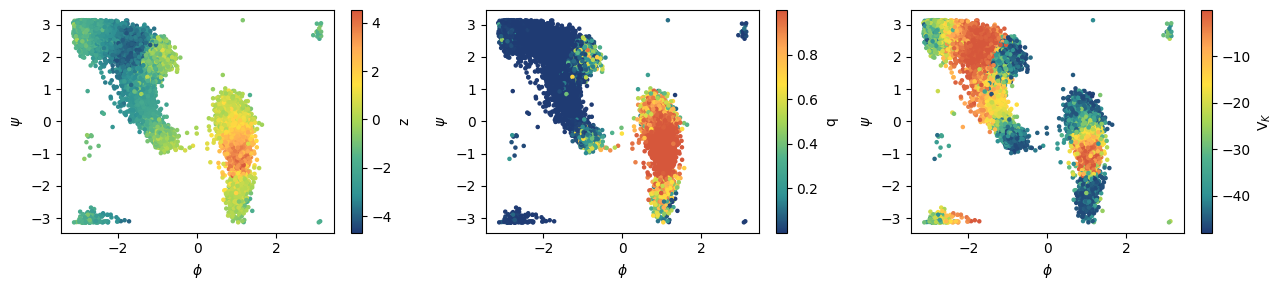

In [235]:
from mlcolvar.cvs.committor.utils import KolmogorovBias

fig, axs = plt.subplots(1,3,figsize=(13,3))

# compute and plot z value over training set
model.sigmoid = None
with torch.no_grad(): out_z = model(test_dataset.get_graph_inputs())

ax = axs[0]
cp = ax.scatter(test_colvar['phi'], test_colvar['psi'], c=out_z, s=5, cmap='fessa')
plt.colorbar(cp, ax=ax, label='z')
ax.set_ylabel("$\psi$")
ax.set_xlabel("$\phi$")



# compute and plot q value over training set
model.sigmoid = sigmoid
with torch.no_grad(): out_q = model(test_dataset.get_graph_inputs()).detach()

ax = axs[1]
cp = ax.scatter(test_colvar['phi'], test_colvar['psi'], c=out_q, s=5, cmap='fessa')
plt.colorbar(cp, ax=ax, label='q')
ax.set_ylabel("$\psi$")
ax.set_xlabel("$\phi$")



# compute and plot V_K value over training set
bias_model = KolmogorovBias(model, beta)
bias = bias_model(test_dataset.get_graph_inputs())

ax = axs[2]
cp = ax.scatter(test_colvar['phi'], test_colvar['psi'], c=bias, s=5, cmap='fessa')
plt.colorbar(cp, ax=ax, label='V$_K$')
ax.set_xlabel("$\phi$")
ax.set_ylabel("$\psi$")


plt.tight_layout()

In [285]:
# loading arguments for each file
load_args = [{'start' : 1000, 'stop' : 10000, 'stride' : 4},
             {'start' : 1000, 'stop' : 10000, 'stride' : 4},
             {'start' : 1000, 'stop' : 10000, 'stride' : 4}]

# create dataset from trajectory files, xyz and anything compatible with MDtraj can be used
dataset = create_dataset_from_trajectories(trajectories=["/home/etrizio@iit.local/notebooks/projects/gnn_committor/alanine/unbiased/A/traj_comp.xtc",     
                                                         "/home/etrizio@iit.local/notebooks/projects/gnn_committor/alanine/unbiased/B/traj_comp.xtc",
                                                         "/home/etrizio@iit.local/notebooks/projects/gnn_committor/alanine//biased/iter_0/B/traj_comp.xtc"],
                                           top="/home/etrizio@iit.local/notebooks/projects/gnn_committor/alanine/unbiased/B/confAvac.gro", # with xyz use none                 
                                           cutoff=10.0,    # Angstrom        
                                           labels=None,                    
                                           system_selection='all and not type H', # this uses MDtraj selection syntax
                                           show_progress=False,
                                           load_args=load_args,
                                           lengths_conversion=10.0, # MDTraj uses nm by defualt, we use Angstroms
                                        )
print('Dataset info:\n', dataset, end="\n\n")


# load corresponding colvar files, the easiest thing is to print in synch trajectory and COLVAR files!
colvar = load_dataframe(["/home/etrizio@iit.local/notebooks/projects/gnn_committor/alanine/unbiased/A/COLVAR",     
                        "/home/etrizio@iit.local/notebooks/projects/gnn_committor/alanine/unbiased/B/COLVAR",
                        "/home/etrizio@iit.local/notebooks/projects/gnn_committor/alanine/biased/iter_0/B/COLVAR"],
                        start=1000,
                        stop=10000,
                        stride=4)


# initialize weights, here we have unbiased simulations so no bias
bias = torch.zeros(len(dataset))
dataset = compute_committor_weights(dataset=dataset,
                                    bias=bias, 
                                    data_groups=[0,1,2], 
                                    beta=beta)


# load dataset into a DictModule
datamodule = DictModule(dataset, lengths=[1])
print('Datamodule info:\n', datamodule)

Dataset info:
 DictDataset( "data_list": 6750, "z_table": [6, 7, 8], "cutoff": 10.0, "used_idx": tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), "used_names": [ACE1-CH3, ACE1-C, ACE1-O, ALA2-N, ALA2-CA, ALA2-CB, ALA2-C, ALA2-O, NME3-N, NME3-C], "data_type": graphs )

Datamodule info:
 DictModule(dataset -> DictDataset( "data_list": 6750, "z_table": [6, 7, 8], "cutoff": 10.0, "used_idx": tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), "used_names": [ACE1-CH3, ACE1-C, ACE1-O, ALA2-N, ALA2-CA, ALA2-CB, ALA2-C, ALA2-O, NME3-N, NME3-C], "data_type": graphs ),
		     train_loader -> DictLoader(length=1, batch_size=6750, shuffle=True))


In [ ]:
# initialize GNN model, here we use SchNet
gnn_model = SchNetModel(n_out=1,
                        cutoff=dataset.metadata['cutoff'],
                        atomic_numbers=dataset.metadata['z_table'],
                        n_bases=16,
                        n_layers=2,
                        n_filters=16,
                        n_hidden_channels=16,
                        aggr='mean',
                        w_out_after_pool=True,
                    )

# model options
options = {'optimizer' : {'lr' : 1e-3},
           'lr_scheduler': {
            'scheduler': torch.optim.lr_scheduler.ExponentialLR,
            'gamma': 0.9999
        }}

# initialize committor model
model = Committor(model=gnn_model, 
                  atomic_masses=torch.Tensor([12.011, 14.007, 15.999]), # C, N, O
                  alpha=1,
                  separate_boundary_dataset=True, # here we only have the boundary dataset
                  z_regularization=100,
                  z_threshold=5,
                  log_var=True,
                  gamma=1,
                  options=options)

# save the model sigmoid to switch easily between q and z
sigmoid = copy.deepcopy(model.sigmoid)

/home/etrizio@iit.local/Bin/miniconda3/envs/graph_mlcolvar_test_2.5/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


In [282]:
# define callbacks
metrics = MetricsCallback()

# initialize lightning trainer
trainer = Trainer(
    callbacks=[metrics],
    logger=False,
    enable_checkpointing=False,
    accelerator='cuda',
    max_epochs=2000,
    enable_model_summary=False,
    limit_val_batches=0, 
    num_sanity_val_steps=0
)

# fit model on datamodule
trainer.fit(model, datamodule)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/etrizio@iit.local/Bin/miniconda3/envs/graph_mlcolvar_test_2.5/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

/home/etrizio@iit.local/Bin/dev/mlcolvar/mlcolvar/core/loss/committor_loss.py:250: UserWarning: Using GNN-based models it may be better to set separate_boundary_dataset to False
  warnings.warn("Using GNN-based models it may be better to set separate_boundary_dataset to False")
`Trainer.fit` stopped: `max_epochs=2000` reached.


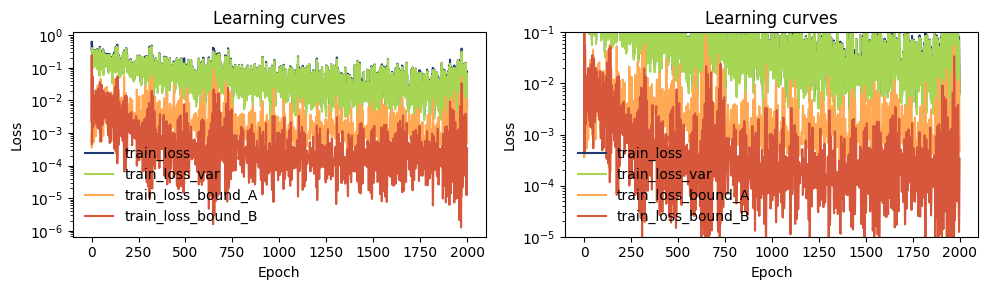

In [283]:
fig, axs = plt.subplots(1,2,figsize=(10,3))
for ax in axs:
    plot_metrics(metrics.metrics,
                    keys=['train_loss', 'train_loss_var', 'train_loss_bound_A', 'train_loss_bound_B'],
                    colors=['fessa0', 'fessa3', 'fessa5', 'fessa6'],
                    yscale='log',
                    ax = ax)

# we zoom more in one plot
axs[1].set_ylim(1e-5, 1e-1)

plt.tight_layout()

torch.Size([6750])


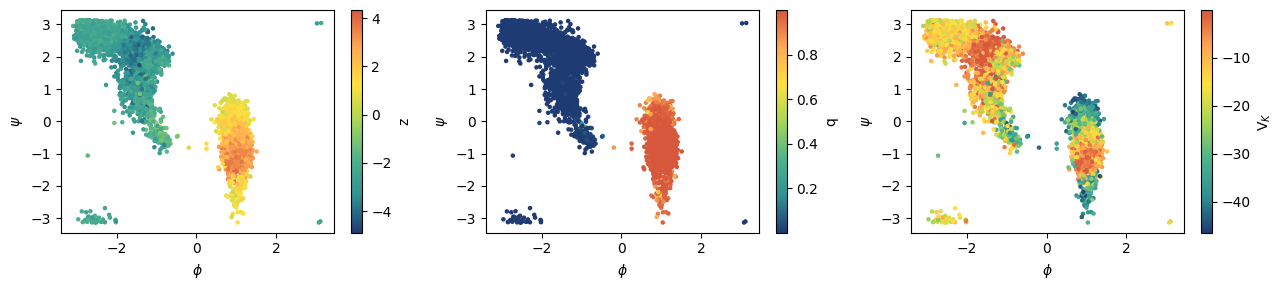

In [286]:
fig, axs = plt.subplots(1,3,figsize=(13,3))

# compute and plot z value over training set
model.sigmoid = None
with torch.no_grad(): out_z = model(dataset.get_graph_inputs())

ax = axs[0]
cp = ax.scatter(colvar['phi'], colvar['psi'], c=out_z, s=5, cmap='fessa')
plt.colorbar(cp, ax=ax, label='z')
ax.set_ylabel("$\psi$")
ax.set_xlabel("$\phi$")



# compute and plot q value over training set
model.sigmoid = sigmoid
with torch.no_grad(): out_q = model(dataset.get_graph_inputs()).detach()

ax = axs[1]
cp = ax.scatter(colvar['phi'], colvar['psi'], c=out_q, s=5, cmap='fessa')
plt.colorbar(cp, ax=ax, label='q')
ax.set_ylabel("$\psi$")
ax.set_xlabel("$\phi$")



# compute and plot V_K value over training set
bias_model = KolmogorovBias(model, beta)
bias = bias_model(dataset.get_graph_inputs())

ax = axs[2]
cp = ax.scatter(colvar['phi'], colvar['psi'], c=bias, s=5, cmap='fessa')
plt.colorbar(cp, ax=ax, label='V$_K$')
ax.set_xlabel("$\phi$")
ax.set_ylabel("$\psi$")


plt.tight_layout()

In [287]:
# export z model
model.sigmoid = None
traced_model = model.to_torchscript('gnn_model_iter_1_z.pt', method='trace')

# export q model
model.sigmoid = sigmoid
traced_model = model.to_torchscript('gnn_model_iter_1_q.pt', method='trace')


# we can also check the outputs coincide
torch.allclose(model(dataset.get_graph_inputs()), traced_model(dataset.get_graph_inputs()))

/home/etrizio@iit.local/Bin/dev/mlcolvar/mlcolvar/data/datamodule.py:322: UserWarning: Length of split at index 1 is 0. This might result in an empty dataset.
  warnings.warn(


True

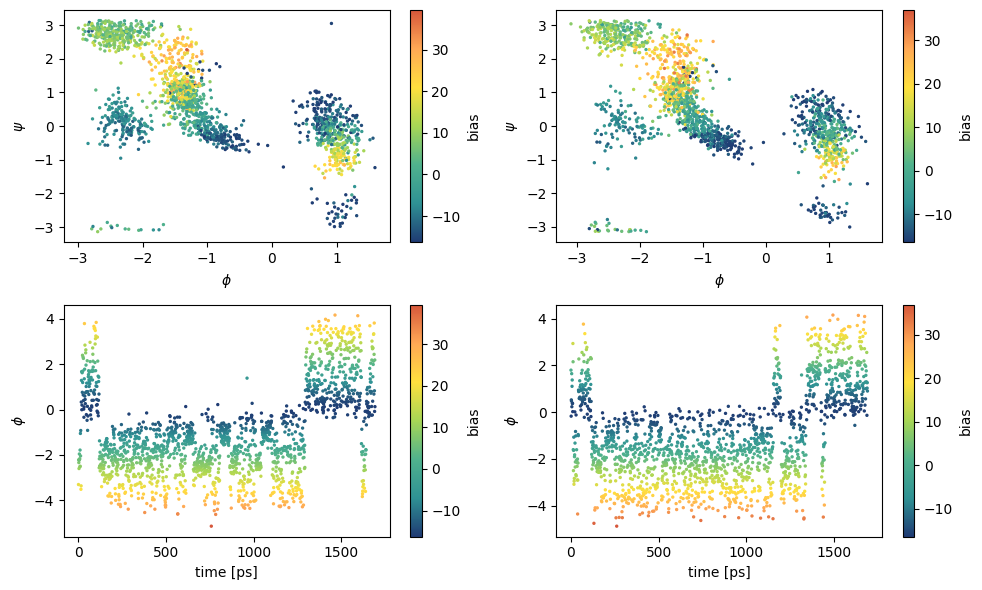

In [294]:
fig, axs = plt.subplots(2,2,figsize=(10,6))

color_plot = 'bias'

ax = axs[0, 0]
sampling = load_dataframe("/home/etrizio@iit.local/notebooks/projects/gnn_committor/alanine/biased/A/COLVAR", stop=-5)
cp = ax.scatter(sampling['phi'], sampling['psi'], c=sampling[color_plot], cmap='fessa', s=2)
plt.colorbar(cp, ax = ax, label=color_plot)
ax.set_xlabel('$\phi$')
ax.set_ylabel('$\psi$')

ax = axs[1, 0]
cp = ax.scatter(sampling['time'], sampling['gnn.node-z'], c=sampling[color_plot], cmap='fessa', s=2)
plt.colorbar(cp, ax = ax, label=color_plot)
ax.set_xlabel('time [ps]')
ax.set_ylabel('$\phi$')

ax = axs[0, 1]
sampling = load_dataframe("/home/etrizio@iit.local/notebooks/projects/gnn_committor/alanine/biased/B/COLVAR", stop=-5)
cp = ax.scatter(sampling['phi'], sampling['psi'], c=sampling[color_plot], cmap='fessa', s=2)
plt.colorbar(cp, ax = ax, label=color_plot)
ax.set_xlabel('$\phi$')
ax.set_ylabel('$\psi$')

ax = axs[1, 1]
cp = ax.scatter(sampling['time'], sampling['gnn.node-z'], c=sampling[color_plot], cmap='fessa', s=2)
plt.colorbar(cp, ax = ax, label=color_plot)
ax.set_xlabel('time [ps]')
ax.set_ylabel('$\phi$')


plt.tight_layout()
plt.show()